In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 16.0

import numpy as np
np.random.seed = 333

# Prepare data

In [2]:
n_samples = 125000

In [3]:
def prepare_data(n_samples):
    data = []
    labels = []
    nuisances = []
    
    for i in range(n_samples):
        sig_bkg = np.random.uniform(low = 0.0, high = 1.0, size = 1)
        if sig_bkg > 0.5:
            nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            data.append(np.random.multivariate_normal(mean = [0.0, nuisance], cov = np.array([[1, -0.5], [-0.5, 1]]), size = 1).flatten())
            labels.append(1.0)
        else:
            nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            data.append(np.random.multivariate_normal(mean = [1.0, nuisance], cov = np.eye(2), size = 1).flatten())
            labels.append(0.0)
            
        nuisances.append(nuisance)
    data = np.array(data)
    labels = np.array(labels)
    nuisances = np.array(nuisances)
    
    return data, labels, nuisances.flatten()

In [4]:
X, y, z = prepare_data(n_samples // 2)

In [5]:
#X = np.vstack([X0, X1])
#y = np.zeros(n_samples)
#y[n_samples // 2:] = 1

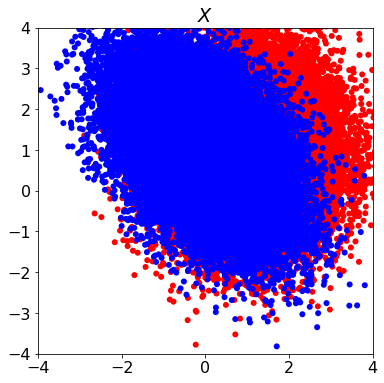

In [6]:
plt.title("$X$")
plt.scatter(X[y==0, 0], X[y==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X[y==1, 0], X[y==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

In [7]:
from sklearn.cross_validation import train_test_split

X_train, X_valid, y_train, y_valid, z_train, z_valid = train_test_split(X, y, z, test_size=50000)

/home/philipp/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Set network architectures

In [8]:
import keras.backend as K
from keras.layers import Input, Dense, Concatenate, Lambda
from keras.models import Model

inputs = Input(shape=(X.shape[1],))
Dx = Dense(20, activation="tanh")(inputs)
Dx = Dense(20, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])

n_components = 5
Rx = D(inputs)
Rx = Dense(20, activation="relu")(Rx)
Rx = Dense(20, activation="relu")(Rx)
mu = Dense(n_components, activation="linear")(Rx)
sigma = Dense(n_components, activation=K.exp)(Rx)
pi = Dense(n_components, activation="softmax")(Rx)
Rx = Concatenate()([mu, sigma, pi])

R = Model(input=[inputs], output=[Rx])

Using TensorFlow backend.
/usr/lib/python3/dist-packages/ipykernel/__main__.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
/usr/lib/python3/dist-packages/ipykernel/__main__.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [9]:
from keras.optimizers import SGD
import keras.backend as K

lam = 10.0 

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        return c * K.binary_crossentropy(y_pred, y_true)
    return loss_D

def make_loss_R(lam, n_components):
    def loss(y_true, y_pred):
        y_true = K.flatten(y_true)
        
        mu = y_pred[:, :n_components]
        sigma = y_pred[:, n_components:2*n_components]
        pi = y_pred[:, 2*n_components:]
        
        pdf = pi[:, 0] * ((1. / np.sqrt(2. * np.pi)) / sigma[:, 0] *
                          K.exp(-(y_true - mu[:, 0]) ** 2 / (2. * sigma[:, 0] ** 2)))
        
        for c in range(1, n_components):
            pdf += pi[:, c] * ((1. / np.sqrt(2. * np.pi)) / sigma[:, c] *
                               K.exp(-(y_true - mu[:, c]) ** 2 / (2. * sigma[:, c] ** 2)))
            
        nll = -K.log(pdf)
        
        return lam * K.mean(nll)
    
    return loss

opt_D = SGD()
D.compile(loss=[make_loss_D(c=1.0)], optimizer=opt_D)

opt_DRf = SGD(lr = 1e-3, momentum=0.0)
DRf = Model(input=[inputs], output=[D(inputs), R(inputs)])
DRf.compile(loss=[make_loss_D(c=1.0), 
                  make_loss_R(-lam, n_components)],   
            optimizer=opt_DRf)

opt_DfR = SGD(lr = 1e-3, momentum=0.0)
DfR = Model(input=[inputs], output=[R(inputs)])
DfR.compile(loss=[make_loss_R(1.0, n_components)], 
            optimizer=opt_DfR)

/usr/lib/python3/dist-packages/ipykernel/__main__.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
/usr/lib/python3/dist-packages/ipykernel/__main__.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [10]:
DRf.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            501         input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 15)           1276        input_1[0][0]                    
Total params: 1,276
Trainable params: 1,276
Non-trainable params: 0
__________________________________________________________________________________________________


In [11]:
DfR.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
model_2 (Model)              (None, 15)                1276      
Total params: 1,276
Trainable params: 1,276
Non-trainable params: 0
_________________________________________________________________


# Pre-training without adversary

In [21]:
# Pretraining of D
D.trainable = True
R.trainable = False
D.fit(X_train, y_train, nb_epoch=10)
min_Lf = D.evaluate(X_valid, y_valid)

Epoch 1/10
 5696/12500 [============>.................] - ETA: 0s - loss: 4.7946

/usr/lib/python3/dist-packages/ipykernel/__main__.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


12500/12500 [==============================] - 0s 24us/step - loss: 4.8791
Epoch 2/10
12500/12500 [==============================] - 0s 25us/step - loss: 4.8704
Epoch 3/10
12500/12500 [==============================] - 0s 21us/step - loss: 4.8666
Epoch 4/10
12500/12500 [==============================] - 0s 22us/step - loss: 4.8883
Epoch 5/10
12500/12500 [==============================] - 0s 21us/step - loss: 4.8775
Epoch 6/10
12500/12500 [==============================] - 0s 19us/step - loss: 4.8599
Epoch 7/10
12500/12500 [==============================] - 0s 21us/step - loss: 4.8839
Epoch 8/10
12500/12500 [==============================] - 0s 27us/step - loss: 4.8635
Epoch 9/10
12500/12500 [==============================] - 0s 22us/step - loss: 4.8901
Epoch 10/10
50000/50000 [==============================] - 0s 9us/step


In [13]:
def make_X(n_samples, z):
    X0 = np.random.multivariate_normal(mean = np.array([0., 0.]), cov = np.array([[1., -0.5], [-0.5, 1.]]),size=n_samples//2)
    X1 = np.random.multivariate_normal(mean = np.array([1.,1.]), cov = np.array([[1.,0],[0,1.]]),size=n_samples//2)
    X1[:, 1] += z
    X = np.vstack([X0, X1])
    y = np.zeros(n_samples)
    y[n_samples // 2:] = 1
    return X

In [14]:
data_test = np.loadtxt("data_test.txt")
nuisances_test = np.loadtxt("nuisances_test.txt")
labels_test = np.loadtxt("labels_test.txt")

/usr/lib/python3/dist-packages/ipykernel/__main__.py:13: MatplotlibDeprecationWarning: The griddata function was deprecated in Matplotlib 2.2 and will be removed in 3.1. Use scipy.interpolate.griddata instead.


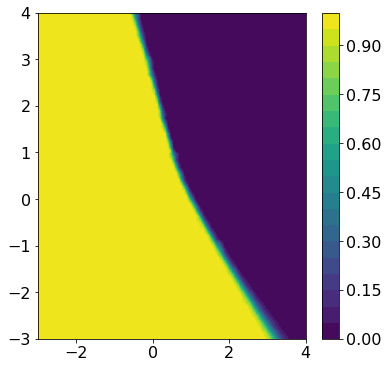

In [32]:
from matplotlib.mlab import griddata

X_test = np.random.rand(30000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 5.

y_pred = D.predict(X_test).ravel()

xi = np.linspace(-3., 4., 100)
yi = np.linspace(-3., 4, 100)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 
#plt.scatter([0], [0], c="red", linewidths=0, label=r"$\mu_0$")
#plt.scatter([1], [0], c="blue", linewidths=0, label=r"$\mu_1|Z=z$")
#plt.scatter([1], [0+1], c="blue", linewidths=0)
#plt.scatter([1], [0+2], c="blue", linewidths=0)
#plt.text(1.2, 0-0.1, "$Z=-\sigma$", color="k")
#plt.text(1.2, 1-0.1, "$Z=0$", color="k")
#plt.text(1.2, 2-0.1, "$Z=+\sigma$", color="k")
plt.xlim(-3,4)
plt.ylim(-3,4)
#plt.legend(loc="upper left", scatterpoints=1)
plt.savefig("surface-plain.pdf")
plt.show()

# Adversarial training of f and r

In [36]:
# Pretraining of R
D.trainable = False
R.trainable = True
DfR.fit(X_train, z_train, nb_epoch=20)

Epoch 1/20
 2688/12500 [=====>........................] - ETA: 0s - loss: 0.7172

/usr/lib/python3/dist-packages/ipykernel/__main__.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
/home/philipp/.local/lib/python3.5/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


12500/12500 [==============================] - 1s 49us/step - loss: 0.7177
Epoch 2/20
12500/12500 [==============================] - 1s 42us/step - loss: 0.7176
Epoch 3/20
12500/12500 [==============================] - 1s 41us/step - loss: 0.7171
Epoch 4/20
12500/12500 [==============================] - 1s 41us/step - loss: 0.7171
Epoch 5/20
12500/12500 [==============================] - 1s 42us/step - loss: 0.7167
Epoch 6/20
12500/12500 [==============================] - 1s 41us/step - loss: 0.7166
Epoch 7/20
12500/12500 [==============================] - 1s 42us/step - loss: 0.7166
Epoch 8/20
12500/12500 [==============================] - 1s 41us/step - loss: 0.7164
Epoch 9/20
12500/12500 [==============================] - 1s 43us/step - loss: 0.7159
Epoch 10/20
12500/12500 [==============================] - 1s 42us/step - loss: 0.7161
Epoch 11/20
12500/12500 [==============================] - 1s 42us/step - loss: 0.7158
Epoch 12/20
12500/12500 [==============================] - 1s 4

In [28]:
losses = {"L_f": [], "L_r": [], "L_f - L_r": []}

In [31]:
batch_size = 128

for i in range(201):
    l = DRf.evaluate(X_valid, [y_valid, z_valid], verbose=0)    
    losses["L_f - L_r"].append(l[0][None][0])
    losses["L_f"].append(l[1][None][0])
    losses["L_r"].append(-l[2][None][0])
    print(losses["L_r"][-1] / lam)
    
    #if i % 5 == 0:
    #    plot_losses(i, losses)

    # Fit D
    D.trainable = True
    R.trainable = False
    indices = np.random.permutation(len(X_train))[:batch_size]
    DRf.train_on_batch(X_train[indices], [y_train[indices], z_train[indices]])
        
    # Fit R
    D.trainable = False
    R.trainable = True
    
    DfR.fit(X_train, z_train, batch_size=batch_size, nb_epoch=1, verbose=1)

#     for j in range(200):
#         indices = np.random.permutation(len(X_train))
#         DfR.train_on_batch(X_train[indices], z_train[indices])

0.729196416168213
Epoch 1/1
12500/12500 [==============================] - 0s 12us/step - loss: 0.7257


/home/philipp/.local/lib/python3.5/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/lib/python3/dist-packages/ipykernel/__main__.py:23: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


0.7295506134490967
Epoch 1/1
12500/12500 [==============================] - 0s 12us/step - loss: 0.7254
0.7298732862091064
Epoch 1/1
12500/12500 [==============================] - 0s 12us/step - loss: 0.7252
0.7292946358337402
Epoch 1/1
12500/12500 [==============================] - 0s 19us/step - loss: 0.7249
0.7298517300872802
Epoch 1/1
12500/12500 [==============================] - 0s 12us/step - loss: 0.7253
0.7291290443878174
Epoch 1/1
12500/12500 [==============================] - 0s 12us/step - loss: 0.7250
0.729605545074463
Epoch 1/1
12500/12500 [==============================] - 0s 12us/step - loss: 0.7246
0.729934817199707
Epoch 1/1
12500/12500 [==============================] - 0s 11us/step - loss: 0.7248
0.7292907357025147
Epoch 1/1
12500/12500 [==============================] - 0s 11us/step - loss: 0.7249
0.7293787614746094
Epoch 1/1
12500/12500 [==============================] - 0s 11us/step - loss: 0.7248
0.7289985003814697
Epoch 1/1
12500/12500 [========================

In [33]:
pred = D.predict(data_test)

In [34]:
group1 = np.logical_and(nuisances_test > 0.0, nuisances_test < 0.5)
group2 = np.logical_and(nuisances_test > 0.5, nuisances_test < 1.0)
group3 = np.logical_and(nuisances_test > 1.0, nuisances_test < 1.5)
group4 = np.logical_and(nuisances_test > 1.5, nuisances_test < 2.0)

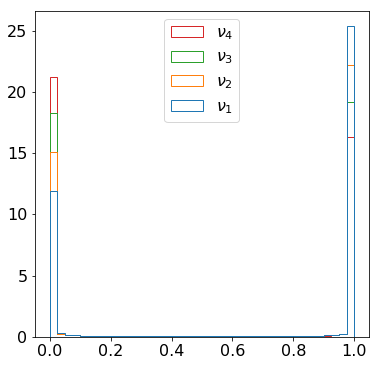

In [35]:
colors = ['red', 'tan', 'lime', 'green']
plt.hist([pred[group1], pred[group2], pred[group3], pred[group4]], label = [r'$\nu_1$', r'$\nu_2$', r'$\nu_3$', r'$\nu_4$'], histtype = 'step', density = True, stacked = False, fill = False, bins = 40)
plt.legend(loc = 'upper center')
#plt.ylim(0, 1)
plt.savefig("pivoting_classifier.pdf")
#plt.show()

In [17]:
sig = data_test[labels_test == 1]
bkg = data_test[labels_test == 0]

In [18]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(labels_test, pred[:])

In [19]:
LL_pred = np.loadtxt("LL_evaluated.csv")

In [20]:
fpr_LL, tpr_LL, thresholds_LL = metrics.roc_curve(labels_test, LL_pred)

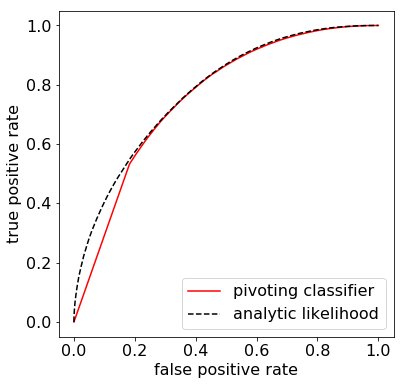

In [21]:
# plot both of them into the same graph
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label = 'pivoting classifier', c = 'red')
ax.plot(fpr_LL, tpr_LL, label = 'analytic likelihood', c = 'black', ls = 'dashed')
leg = ax.legend(loc = 'lower right')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
#plt.show()
plt.savefig("pivoting_ROC.pdf")

/usr/lib/python3/dist-packages/ipykernel/__main__.py:3: MatplotlibDeprecationWarning: The griddata function was deprecated in Matplotlib 2.2 and will be removed in 3.1. Use scipy.interpolate.griddata instead.
  app.launch_new_instance()
/home/philipp/.local/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'interp'
  s)


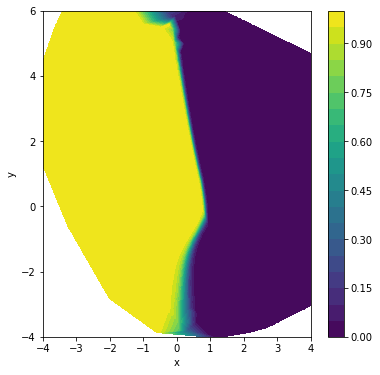

In [80]:
xi = np.linspace(-4, 4, 1000)
yi = np.linspace(-4, 6, 1000)
zi = griddata(data_test[:, 0], data_test[:, 1], np.squeeze(pred), xi, yi, interp = "linear")

plt.contourf(xi, yi, zi, interp='linear', levels = 20)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.savefig("pivoting_classifier_contours.pdf")